<img src="images/csdms_logo.jpg">

# Using a BMI: Coastline Evolution Model
This example explores how to use a BMI implementation using the CEM model as an example.

## Links
* [CEM source code](https://github.com/csdms/cem-old): Look at the files that have *deltas* in their name.
* [CEM description on CSDMS](http://csdms.colorado.edu/wiki/Model_help:CEM): Detailed information on the CEM model.

# Interacting with the Coastline Evolution Model BMI using Python

Some magic that allows us to view images within the notebook.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import the `Cem` class, and instantiate it. In Python, a model with a BMI will have no arguments for its constructor. Note that although the class has been instantiated, it's not yet ready to be run. We'll get to that later!

In [2]:
from csdms.Cem import Cem
cem = Cem()

Even though we can't run our waves model yet, we can still get some information about it. *Just don't try to run it.* Some things we can do with our model are get the names of the input variables.

In [3]:
cem.get_output_var_names()[1]

array(['basin_outlet~coastal_center__x_coordinate',
       'basin_outlet~coastal_water_sediment~bedload__mass_flow_rate',
       'land_surface__elevation', 'sea_water__depth',
       'basin_outlet~coastal_center__y_coordinate'], dtype=object)

In [4]:
cem.get_input_var_names()[1]

array(['sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity',
       'basin_outlet_water_sediment~bedload__mass_flow_rate',
       'land_surface_water_sediment~bedload__mass_flow_rate',
       'sea_surface_water_wave__period',
       'basin_outlet_water_sediment~suspended__mass_flow_rate',
       'sea_surface_water_wave__height'], dtype=object)

We can also get information about specific variables. Here we'll look at some info about wave direction. This is the main input of the Cem model. Notice that BMI components always use [CSDMS standard names](http://csdms.colorado.edu/wiki/CSDMS_Standard_Names). The CSDMS Standard Name for wave angle is,

    "sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity"

Quite a mouthful, I know. With that name we can get information about that variable and the grid that it is on (it's actually not a one).

In [5]:
angle_name = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'

print "Data type: %s" % cem.get_var_type(angle_name)[1]
print "Units: %s" % cem.get_var_units(angle_name)[1]
print "Grid id: %d" % cem.get_var_grid(angle_name)[1]
print "Number of elements in grid: %d" % cem.get_grid_size(0)[1]
print "Type of grid: %s" % cem.get_grid_type(0)[1]

Data type: double
Units: radians
Grid id: 0
Number of elements in grid: 1
Type of grid: scalar


OK. We're finally ready to run the model. Well not quite. First we initialize the model with the BMI **initialize** method. Normally we would pass it a string that represents the name of an input file. For this example we'll pass **None**, which tells Cem to use some defaults.

In [6]:
cem.initialize(None)

0

Before running the model, let's set a couple input parameters. These two parameters represent the wave height and wave period of the incoming waves to the coastline.

In [7]:
import numpy as np

cem.set_value(angle_name, np.array((0.1, )))
cem.set_value("sea_surface_water_wave__height", np.array((2., )))
cem.set_value("sea_surface_water_wave__period", np.array((7., )))
cem.set_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity", np.array((0.1, )))

0

The main output variable for this model is *water depth*. In this case, the CSDMS Standard Name is much shorter:

    "sea_water__depth"

First we find out which of Cem's grids contains water depth. 

In [8]:
grid_id = cem.get_var_grid('sea_water__depth')[1]

With the *grid_id*, we can now get information about the grid. For instance, the number of dimension and the type of grid (structured, unstructured, etc.). This grid happens to be *uniform rectilinear*. If you were to look at the "grid" types for wave height and period, you would see that they aren't on grids at all but instead are scalars.

In [9]:
grid_type = cem.get_grid_type(grid_id)[1]
grid_rank = cem.get_grid_rank(grid_id)[1]
print 'Type of grid: %s (%dD)' % (grid_type, grid_rank)

Type of grid: uniform_rectilinear (2D)


Because this grid is uniform rectilinear, it is described by a set of BMI methods that are only available for grids of this type. These methods include:
* get_grid_shape
* get_grid_spacing
* get_grid_origin

In [10]:
shape = np.empty((grid_rank, ), dtype='int32')
spacing = np.empty((grid_rank, ), dtype=float)

cem.get_grid_shape(grid_id, shape)
cem.get_grid_spacing(grid_id, spacing)

print 'The grid has %d rows and %d columns' % (shape[0], shape[1])
print 'The spacing between rows is %f and between columns is %f' % (spacing[0], spacing[1])

The grid has 120 rows and 200 columns
The spacing between rows is 100.000000 and between columns is 100.000000


Allocate memory for the water depth grid and get the current values from `cem`.

In [11]:
z = np.empty(shape, dtype=float)
cem.get_value('sea_water__depth', z)

0

Here I define a convenience function for plotting the water depth and making it look pretty. You don't need to worry too much about it's internals for this tutorial. It just saves us some typing later on.

In [12]:
def plot_coast(spacing, z):
    xmin, xmax = 0., z.shape[1] * spacing[0] * 1e-3
    ymin, ymax = 0., z.shape[0] * spacing[1] * 1e-3

    imshow(z, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='ocean')
    colorbar().ax.set_ylabel('Water Depth (m)')
    xlabel('Along shore (km)')
    ylabel('Cross shore (km)')

It generates plots that look like this. We begin with a flat delta (green) and a linear coastline (y = 3 km). The bathymetry drops off linearly to the top of the domain.

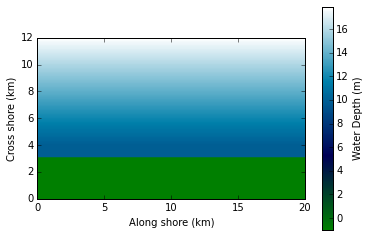

In [13]:
plot_coast(spacing, z)

Right now we have waves coming in but no sediment entering the ocean. To add some discharge, we need to figure out where to put it. For now we'll put it on a cell that's next to the ocean.

In [14]:
water_depth = z[:, 100]
river_mouth = np.where(water_depth > 0.)[0][0]
river_mouth

31

Allocate memory for the sediment discharge array and set the discharge at the coastal cell to some value.

In [15]:
qs = np.zeros_like(z)
qs[0, 100] = 1250

In [16]:
def prograde(col, flux, z, qs):
    water_depth = z[:, col]
    river_mouth = np.where(water_depth > 0.)[0][0]
    qs.fill(0.)
    qs[river_mouth - 1, col] = flux

The CSDMS Standard Name for this variable is:

    "land_surface_water_sediment~bedload__mass_flow_rate"

You can get an idea of the units based on the quantity part of the name. "mass_flow_rate" indicates mass per time. You can double-check this with the BMI method function **get_var_units**.

In [17]:
cem.get_var_units('land_surface_water_sediment~bedload__mass_flow_rate')[1]

'kg / s'

Set the bedload flux and run the model.

In [18]:
for time in xrange(3500):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs.flatten())
    cem.update(time)

cem.get_value('sea_water__depth', z)

0

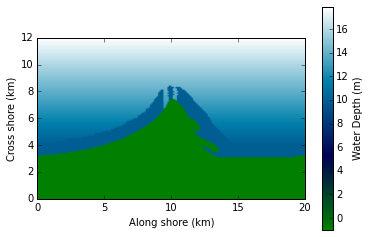

In [19]:
plot_coast(spacing, z)

In [20]:
val = np.empty((5, ), dtype=float)
cem.get_value("basin_outlet~coastal_center__x_coordinate", val)
val / 100.

array([  7.30000000e+01,   5.00000000e-02,   1.00000000e-01,
         1.50000000e-01,   2.00000000e-01])

Let's add another sediment source with a different flux and update the model.

In [21]:
qs[0, 150] = 1500
for time in xrange(3750):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs.flatten())
    cem.update(time)
    
cem.get_value('sea_water__depth', z)

0

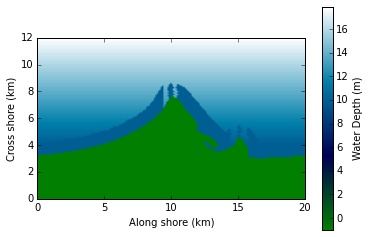

In [22]:
plot_coast(spacing, z)

Here we shut off the sediment supply completely.

In [23]:
qs.fill(0.)
for time in xrange(4000):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs.flatten())
    cem.update(time)
    
cem.get_value('sea_water__depth', z)

0

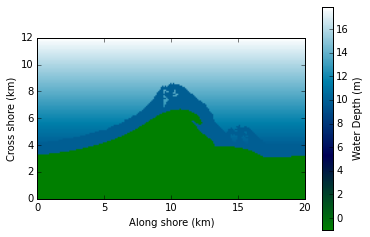

In [24]:
plot_coast(spacing, z)